## I. Project Description
Academic success is a priority for students, faculty, and administration alike, and identifying students who may struggle can have a transformative impact. Since many factors can influence whether a student passes or fails, I decided to build a model to predict student performance based on some of the most relevant indicators. This model could provide early insights into student progress, helping educators and administrators offer timely interventions—such as tutoring, counseling, or customized learning plans—to improve the likelihood of course completion and support academic success.

This data set has around <b>40,000 rows</b> and <b>7 variables</b>: 2 boolean, 2 string, and 3 decimal
    <ul>
        <li>The booleans include participation in extracurricular activities and passed.</li>
        <li>The strings include student ID and parent education level.</li>
        <li>The decimals include study hours per week, attendance rate and previous grades.</li>
    </ul>

From the data, the dependent variable (y) we are trying to predict is `Passed`, and the rest are feature variables.

## II. Data Analysis
### A. Project Functions
I will use below modules to support my model development:
<ul>
    <li><b>numpy</b>, <b>pandas</b>, and <b>copy</b>: to handle data cleaning and calculation</li>
    <li><b>matplotlib</b>: to graph data</li>
    <li><b>sklearn</b>: to run classification models</li>
</ul>

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import mixture

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import svm, linear_model, datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, RocCurveDisplay, roc_auc_score, accuracy_score, classification_report

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import export_text
from sklearn.utils.class_weight import compute_class_weight
from scipy.stats import pointbiserialr
from scipy.stats import chi2_contingency

import warnings
warnings. filterwarnings('ignore')

### B. Loading Data
The dataset was downloaded from [Kaggle](https://www.kaggle.com/datasets/souradippal/student-performance-prediction/discussion/529331): `student_performance_prediction.csv`

In [7]:
df = pd.read_csv("student_performance_prediction.csv")
df.head(5)

,Student ID,Passed,Study Hours per Week,Attendance Rate,Previous Grades,Participation in Extracurricular Activities,Parent Education Level
0,S00001,Yes,12.5,NaN,75.0,Yes,Master
1,S00002,No,9.3,95.3,60.6,No,High School
2,S00003,No,13.2,NaN,64.0,No,Associate
3,S00004,No,17.6,76.8,62.4,Yes,Bachelor
4,S00005,No,8.8,89.3,72.7,No,Master


### C. Reviewing Data
#### 1. Check NA values
To evaluate the completeness of the dataset, we examined each variable for missing values. The results indicate that:
<ul>
    <li>The Student ID variable contains no missing values.</li>
    <li>Variables such as Study Hours per Week, Attendance Rate, Previous Grades, Participation in Extracurricular Activities, Parent Education Level, and Passed each contain missing entries.</li>
</ul>

In [9]:
rows, variables = df.shape
print(f"Number of rows: {rows}")
print(f"Number of variables: {variables}")

Number of rows: 40000
Number of variables: 7


In [10]:
df.isna().any()

Student ID                                     False
Passed                                          True
Study Hours per Week                            True
Attendance Rate                                 True
Previous Grades                                 True
Participation in Extracurricular Activities     True
Parent Education Level                          True
dtype: bool

In [11]:
df.isna().sum()

Student ID                                        0
Passed                                         2000
Study Hours per Week                           1995
Attendance Rate                                1992
Previous Grades                                1994
Participation in Extracurricular Activities    2000
Parent Education Level                         2000
dtype: int64

#### 2. Check duplicate values
No duplicate values are found.

In [13]:
df.duplicated().sum()

0

#### 3. Check class distribution
Class sizes are almost equal; the dataset is balanced.

In [15]:
df['Passed'].value_counts()

Passed
Yes    19011
No     18989
Name: count, dtype: int64

#### 4. Check all unique values of each variable
Doing so gives us a sense of necessary data conversion needed.
By checking unique values of each variable, we can see that:
<ul>
    <li>Study Hours per Week: values range from -12.3 to 32.4, indicating potential outliers or errors.</li>
    <li>Attendance Rate: some values exceed 100%.</li>
    <li>Previous Grades: values primarily range between 0 and 100, but some values exceed 100. </li>
    <li>Parent Education Level: contains nominal categorical values.</li>
</ul>

In [17]:
df.nunique()

Student ID                                     40000
Passed                                             2
Study Hours per Week                             355
Attendance Rate                                 1235
Previous Grades                                  956
Participation in Extracurricular Activities        2
Parent Education Level                             5
dtype: int64

### D. Cleaning and Preprocessing Data

In [19]:
# Create a copy of the original data frame
df_copy = copy.copy(df)

In [20]:
df_copy.drop(columns=['Student ID'], inplace=True)

#### 1. Handle outliers
<ul>
    <li>Study Hours per Week: negative values are replaced with absolute value, transforming the negative hours into positive</li>
    <li>Attendance Rate: values greater than 100 or less than 0 are removed</li>
    <li>Previous Grades: values greater than 100 are removed</li>
</ul>

In [22]:
df_copy['Study Hours per Week'] = df_copy['Study Hours per Week'].abs()

In [23]:
df_copy = df_copy[(df_copy['Attendance Rate'] >= 0) & (df_copy['Attendance Rate'] <= 100)]

In [24]:
df_copy = df_copy[df_copy['Previous Grades'] <= 100]

#### 2. Impute missing values

In [26]:
df_copy['Attendance Rate'].fillna(df_copy['Attendance Rate'].mean(), inplace=True)
df_copy['Attendance Rate'] = df_copy['Attendance Rate'].round(2)
df_copy['Study Hours per Week'].fillna(df_copy['Study Hours per Week'].mean(), inplace=True)
df_copy['Previous Grades'].fillna(df_copy['Previous Grades'].mean(), inplace=True)
df_copy['Parent Education Level'].fillna(df_copy['Parent Education Level'].mode()[0], inplace=True)
df_copy['Participation in Extracurricular Activities'].fillna(df_copy['Participation in Extracurricular Activities'].mode()[0], inplace=True)
df_copy['Passed'].fillna(df_copy['Passed'].mode()[0], inplace=True)

In [27]:
df_copy.isna().sum()

Passed                                         0
Study Hours per Week                           0
Attendance Rate                                0
Previous Grades                                0
Participation in Extracurricular Activities    0
Parent Education Level                         0
dtype: int64

In [28]:
df_copy.shape

(31774, 6)

In [29]:
df_copy.nunique()

Passed                                           2
Study Hours per Week                           273
Attendance Rate                                866
Previous Grades                                814
Participation in Extracurricular Activities      2
Parent Education Level                           5
dtype: int64

#### 3. Converse data
<ul>
    <li> For the 2 binary variables, I replaced their binary values with 0’s and 1’s.
    <li> For the nominal categorical variable Parent Education Level, I used one-hot encoding to handle it.
<ul>

In [31]:
# Encode binary variables
df_copy.replace(('Yes', 'No'), (1,0), inplace=True)

In [32]:
# Create one copy of the copied version that experienced the cleaning data process from missing values and outliers
df_copy2 = copy.copy(df_copy)

In [33]:
# One-hot encoding
df_copy2 = df_copy2.join(pd.get_dummies(df_copy2['Parent Education Level'], drop_first=False)) #Keep all newly generated features for classification
df_copy2 = df_copy2.drop(columns='Parent Education Level')

In [34]:
df_copy2.head(5)

,Passed,Study Hours per Week,Attendance Rate,Previous Grades,Participation in Extracurricular Activities,Associate,Bachelor,Doctorate,High School,Master
1,0,9.3,95.3,60.6,0,False,False,False,True,False
3,0,17.6,76.8,62.4,1,False,True,False,False,False
4,0,8.8,89.3,72.7,0,False,False,False,False,True
5,1,8.8,73.8,69.3,1,False,False,False,True,False
6,1,17.9,38.6,93.6,0,False,False,True,False,False


In [35]:
rows, variables = df_copy2.shape
print(f"Number of rows: {rows}")
print(f"Number of variables: {variables}")

Number of rows: 31774
Number of variables: 10


In [36]:
df_copy2.isna().sum()

Passed                                         0
Study Hours per Week                           0
Attendance Rate                                0
Previous Grades                                0
Participation in Extracurricular Activities    0
Associate                                      0
Bachelor                                       0
Doctorate                                      0
High School                                    0
Master                                         0
dtype: int64

In [37]:
df_copy2['Passed'].value_counts()

Passed
0    16762
1    15012
Name: count, dtype: int64

In [38]:
df_copy2.nunique()

Passed                                           2
Study Hours per Week                           273
Attendance Rate                                866
Previous Grades                                814
Participation in Extracurricular Activities      2
Associate                                        2
Bachelor                                         2
Doctorate                                        2
High School                                      2
Master                                           2
dtype: int64

In [39]:
df_copy2.dtypes

Passed                                           int64
Study Hours per Week                           float64
Attendance Rate                                float64
Previous Grades                                float64
Participation in Extracurricular Activities      int64
Associate                                         bool
Bachelor                                          bool
Doctorate                                         bool
High School                                       bool
Master                                            bool
dtype: object

#### 4. Check correlation among feature variables
After encoding all variables, I found no significant correlations. Therefore, from the statistical point of view, we could keep all variables when modeling.

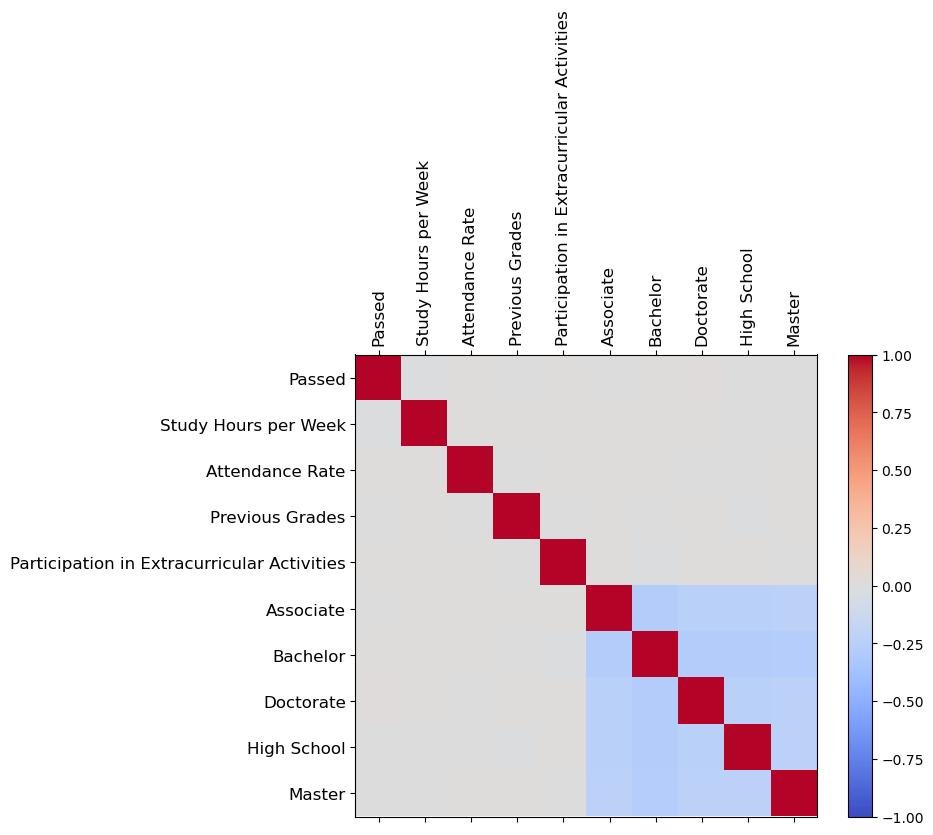

In [41]:
corr = df_copy2.corr()
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(df_copy2.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90, fontsize=12, color = 'k')
plt.yticks(fontsize=12, color = 'k')
ax.set_yticks(ticks)
ax.set_xticklabels(df_copy2.columns, color = 'k')
ax.set_yticklabels(df_copy2.columns, color = 'k')
plt.show()

### E. Modeling 

Using encoded variables and splitting them into 80% training, 10% validation, and 10% testing sets with stratify = y, I then tried multiple models and the grid search method to find the models and parameters that performed the best. Since the label variable and the feature variables are categorical/binary variables, I tried classification models only.

In [44]:
# Separate features and target variable
X = df_copy2.drop(columns=['Passed'])  # Features
y = df_copy2['Passed']                 # Target
# Split the dataset into training, validation, and test sets
X_train, X_tmp, y_train, y_tmp = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)
X_valid, X_test, y_valid, y_test = train_test_split(X_tmp, y_tmp, test_size=0.5, random_state=0, stratify=y_tmp)

In [45]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (25419, 9)
y_train shape: (25419,)
X_test shape: (3178, 9)
y_test shape: (3178,)


In [46]:
# Convert the classes to numpy array
classes_array = np.array([0, 1])

# Compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=classes_array, y=y_train)
class_weights_dict = {0: class_weights[0], 1: class_weights[1]}

print("Class Weights:", class_weights_dict)

Class Weights: {0: 0.9478335446342009, 1: 1.0582431307243962}


In [47]:
# Scale the numerical features (Study Hours per Week, Attendance Rate, Previous Grades)
scaler = MinMaxScaler()

# Apply MinMaxScaler to the specified columns in the training, validation, and test sets
X_train[['Study Hours per Week', 'Attendance Rate', 'Previous Grades']] = scaler.fit_transform(
    X_train[['Study Hours per Week', 'Attendance Rate', 'Previous Grades']]
)
X_valid[['Study Hours per Week', 'Attendance Rate', 'Previous Grades']] = scaler.transform(
    X_valid[['Study Hours per Week', 'Attendance Rate', 'Previous Grades']]
)
X_test[['Study Hours per Week', 'Attendance Rate', 'Previous Grades']] = scaler.transform(
    X_test[['Study Hours per Week', 'Attendance Rate', 'Previous Grades']]
)

#### Experimenting with Logistic Regression, Decision Tree, Random Forest, Gradient Boosting
<ul>
    <li> All ML models achieve an accuracy of around 50%-53%, even using class_weight to deal with class imbalance, changing hyperparameters in each model, and trying different data split, suggesting that the models struggle to differentiate between classes effectively.
    <li> The potential reason for the limited performance and the area for improvement:
    <ul>
        <li> The input features do not have a strong correlation with a target variable, so the features might not contain enough information to distinguish between the classes => The dataset may not be ideal for building predictive models
        <li> The current dataset should add more features with significant predictive power, such as participation in class through discussion, accumulative grade, teaching quality and etc. </li>
    </ul>
</ul>

In [ ]:
models = {
    "Logistic Regression": linear_model.LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier()
}
param_grids = {
    "Logistic Regression": {'C': [0.01, 0.1, 1, 10], 'penalty': ['l2'], 'solver': ['liblinear', 'lbfgs'], 'max_iter': [500, 1000], 'class_weight':[class_weights_dict]},
    "Decision Tree": {'max_depth': [5, 10, 20],'min_samples_split': [2, 10, 20],'min_samples_leaf': [2, 5, 10], 'class_weight': [class_weights_dict]},
    "Random Forest": {'n_estimators': [50, 100, 200],'max_depth': [10, 20, None],'min_samples_split': [5, 10], 'min_samples_leaf': [2, 5],'class_weight': [class_weights_dict]},
    "Gradient Boosting": {'learning_rate': [0.01, 0.1, 0.2],'n_estimators': [50, 100, 200],'max_depth': [3, 5, 7], 'min_samples_split': [5, 10],'min_samples_leaf': [2, 5]}
}
for model_name, model in models.items():
    print(f"Running GridSearchCV for {model_name}")
    grid_search = GridSearchCV(estimator=model, param_grid=param_grids[model_name],
                               cv=5, n_jobs=-1, verbose=2, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    
    print(f"Best parameters for {model_name}: {grid_search.best_params_}")
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_valid)
    print(f"Validation Accuracy for {model_name}: {accuracy_score(y_valid, y_pred)}")
    print("-" * 50)


Running GridSearchCV for Logistic Regression
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters for Logistic Regression: {'C': 0.01, 'class_weight': {0: 0.9478335446342009, 1: 1.0582431307243962}, 'max_iter': 500, 'penalty': 'l2', 'solver': 'lbfgs'}
Validation Accuracy for Logistic Regression: 0.5136921624173749
--------------------------------------------------
Running GridSearchCV for Decision Tree
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best parameters for Decision Tree: {'class_weight': {0: 0.9478335446342009, 1: 1.0582431307243962}, 'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 2}
Validation Accuracy for Decision Tree: 0.5001573811772112
--------------------------------------------------
Running GridSearchCV for Random Forest
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters for Random Forest: {'class_weight': {0: 0.9478335446342009, 1: 1.0582431307243962}, 'max_depth': None, 'min_samples_l

#### Check the relationship among input feature variables and target variable
Both numerical and categorical features show weak or negligible relationships with the target variable (Passed), indicating that these features alone are insufficient predictors
<ul>
    <li> All numerical features have correlations close to zero, so they are not strongly related to the target variable.
    <li> None of the categorical features have a statistically significant relationship with the target variable, as all p-values are greater than 0.05.
<ul>

In [ ]:
# Use Point Biserial Correlation to check the relationship between numerical input features and the target variable
target = "Passed"
for col in df_copy2.select_dtypes(include=['int64', 'float64']).columns:
    if col != target:
        corr, _ = pointbiserialr(df_copy2[col], df_copy2[target])
        print(f"Point Biserial Correlation between {col} and {target}: {corr}")

In [ ]:
# Use the Chi-Squared Test to test the dependencies of boolean input features with the target variable
target = "Passed"
for col in df_copy2.select_dtypes(include=['bool']).columns:
    if col != target:
        contingency_table = pd.crosstab(df_copy2[col], df_copy2[target])
        chi2, p, dof, _ = chi2_contingency(contingency_table)
        print(f"Chi2 Test for {col}: Chi2={chi2}, p-value={p}")

In [ ]:
#Save the cleaned data to a CSV file
#df_copy2.to_csv('clean_data.csv', index=False)

In [ ]:
#from IPython.display import FileLink

# Generate a download link
#display(FileLink('clean_data.csv'))